In [1]:
%%capture --no-display
from dask.distributed import Client
client = Client(address = 'tcp://192.168.62.207:8786')
client

Client Scheduler: tcp://192.168.62.207:8786 Dashboard: http://192.168.62.207:8787/status,Cluster Workers: 10 Cores: 10 Memory: 673.47 GB


In [5]:
import dask.bag as db
import json
bag = db.read_text(f'hdfs://bricks07:9000/user/kruit/output/tabel-small/9-triples/*').map(json.loads).persist()
bag.count().compute()

16778

In [6]:
triples = bag.map(lambda x:x['triples']).flatten().distinct('hash').persist()
triples.count().compute()

14462337

## Property tail

In [7]:
import trident
g = trident.Db('/export/scratch1/home/kruit/nary/data/wikidata.tridentdb')
p_count = {p: g.count_p(p) for p in g.all_p()}
wikiprops = '/export/scratch1/home/kruit/nary/data/kb/wikidata/wikidata-properties.txt'
puri_name = {
    l.split(' ', 1)[0]: l 
    for l in map(str.strip, open(wikiprops))
}
def pname(p):
    puri = g.lookup_str(p)
    if puri:
        return puri_name.get(puri[1:-1].replace('http://www.wikidata.org/prop/direct/', ''))

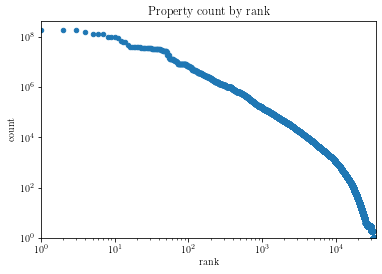

In [20]:
import pandas as pd
df = pd.Series(p_count).to_frame('count')
df = df.sort_values('count', ascending=False).reset_index()
df['rank'] = df.index

def plot_tail(caption, df, x, y):
    ax = df.plot.scatter(x, y, loglog=True, xlim=[1,df[x].max()], ylim=[1,df[y].max()])
    ax.set_title(caption)
    return ax


ax = plot_tail('Property count by rank', df, 'rank', 'count')
ax.get_figure().savefig('fig/property-count-by-rank.png', format='png')
ax

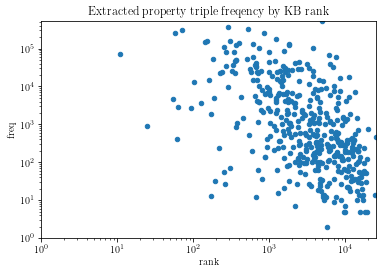

In [28]:
def props(tables):
    ps = []
    for t in tables:
        for tr in t.get('triples'):
            if tr.get('kind') == 'property':
                ps.append(tr.get('p'))
    return ps
            
from collections import Counter
freq = dict(bag.map_partitions(props).frequencies())
p_freq = pd.Series({g.lookup_id(f'<{puri}>'):f for puri,f in freq.items()}, name='freq')
df2 = df.join(p_freq, on='index')
df2 = df2[~df2['freq'].isna()]
ax = df2.plot.scatter('rank', 'freq', loglog=True, xlim=[1,df2['rank'].max()], ylim=[1,df2['freq'].max()])
ax.set_title("Extracted property triple freqency by KB rank")
ax.get_figure().savefig('fig/extracted-property-count-by-rank.png')
ax

In [29]:
for p in df2.loc[(df2['freq'] / df2['count']).sort_values().index[::-1]][:10].itertuples():
    print(pname(p.index), p.count, p.freq)

P7169 substitute director/manager 5 473.0
P530 diplomatic relation 6658 543251.0
P3279 statistical leader 2243 59013.0
P1002 engine configuration 715 17309.0
P2095 co-driver 36 733.0
P634 captain 349 7044.0
P3022 flag bearer 3742 68258.0
P113 airline hub 2960 33368.0
P3764 pole position 3657 38538.0
P521 scheduled service destination 1715 17131.0


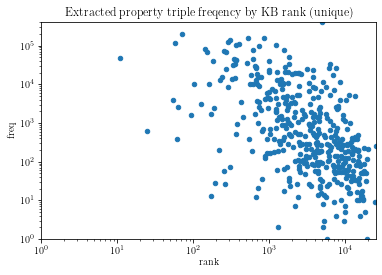

In [30]:
def tprops(triples):
    ps = []
    for tr in triples:
        if tr.get('kind') == 'property':
            ps.append(tr.get('p'))
    return ps

freq = dict(triples.map_partitions(tprops).frequencies().compute())
p_freq = pd.Series({g.lookup_id(f'<{puri}>'):f for puri,f in freq.items()}, name='freq')
df2 = df.join(p_freq, on='index')
df2 = df2[~df2['freq'].isna()]

ax = plot_tail('Extracted property triple freqency by KB rank (unique)', df2, 'rank', 'freq')
ax.get_figure().savefig('fig/extracted-unique-property-count-by-rank.png')
ax

In [31]:
for p in df2.loc[(df2['freq'] / df2['count']).sort_values().index[::-1]][:10].itertuples():
    print(pname(p.index), p.count, p.freq)

P530 diplomatic relation 6658 419275.0
P7169 substitute director/manager 5 248.0
P634 captain 349 4870.0
P3279 statistical leader 2243 25773.0
P3764 pole position 3657 33870.0
P2937 parliamentary term 690 5408.0
P3022 flag bearer 3742 27255.0
P521 scheduled service destination 1715 11506.0
P2095 co-driver 36 212.0
P113 airline hub 2960 17125.0


In [33]:
pcode = 'P634' # captain

def so(triples, pid):
    for t in triples:
        if t.get('p', '').endswith(pid):
            score = t.get('s_score', 1) , min(1, t.get('p_score',1)), t.get('o_score', 1)
            yield t.get('s'), t.get('o'), score
            
pid = g.lookup_id(f'<http://www.wikidata.org/prop/direct/{pcode}>')
for su, ou, score in triples.map_partitions(so, pcode).take(10):
    s, o = g.lookup_id('<%s>'%su), g.lookup_id('<%s>'%ou)
    print(su, ou, g.exists(s,pid,o), score)

http://www.wikidata.org/entity/Q18741 http://www.wikidata.org/entity/Q184586 False (1, 0.06060606060606061, 1)
http://www.wikidata.org/entity/Q2641 http://www.wikidata.org/entity/Q167790 False (1, 0.06060606060606061, 1)
http://www.wikidata.org/entity/Q483020 http://www.wikidata.org/entity/Q167790 False (1, 0.06060606060606061, 1)
http://www.wikidata.org/entity/Q483020 http://www.wikidata.org/entity/Q210453 False (1, 0.06060606060606061, 1)
http://www.wikidata.org/entity/Q483020 http://www.wikidata.org/entity/Q46896 False (1, 0.06060606060606061, 1)
http://www.wikidata.org/entity/Q8701 http://www.wikidata.org/entity/Q138172 False (1, 0.06060606060606061, 1)
http://www.wikidata.org/entity/Q180305 http://www.wikidata.org/entity/Q138172 False (1, 0.06060606060606061, 1)
http://www.wikidata.org/entity/Q9616 http://www.wikidata.org/entity/Q214204 False (1, 0.06060606060606061, 1)
http://www.wikidata.org/entity/Q207346 http://www.wikidata.org/entity/Q214204 False (1, 0.06060606060606061, 1)


In [34]:
triples.filter(lambda t: t['kind'] == 'property' and t['p'].endswith(pcode)).take(1)

({'kind': 'property',
  's': 'http://www.wikidata.org/entity/Q18741',
  'p': 'http://www.wikidata.org/prop/direct/P634',
  's_score': 1,
  'p_score': 0.06060606060606061,
  'col': 1,
  'row': 0,
  'gold': None,
  'pred': True,
  'o': 'http://www.wikidata.org/entity/Q184586',
  'o_score': 1,
  'hash': -6999206755940560059},)

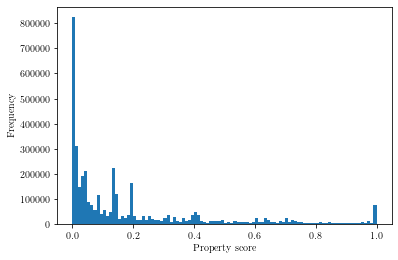

In [38]:
def get_p_score(ts):
    return [min(1,t['p_score']) for t in ts if t['kind'] == 'property' and 'p_score' in t]

p_scores = triples.map_partitions(get_p_score).compute()
ax = pd.Series(p_scores).plot.hist(bins=100)
ax.set(xlabel='Property score')
ax.get_figure().savefig('fig/property-scores.png')
ax

## Subject tail

In [40]:
def get_uris(ts):
    return [i.rsplit('/', 1)[-1] for t in ts for i in [t.get('s'), t.get('o')] if isinstance(i, str)]

all_uris = set(triples.map_partitions(get_uris).distinct().compute())
len(all_uris)

967388

In [41]:
import tqdm
ss = set(g.lookup_id(f'<http://www.wikidata.org/entity/{u}>') for u in tqdm.tqdm(all_uris))
len(ss)

100%|██████████| 967388/967388 [02:33<00:00, 6318.76it/s] 


966404

100%|██████████| 966404/966404 [02:56<00:00, 5486.45it/s] 


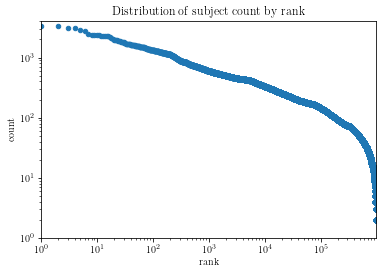

In [42]:
s_count = {s: g.count_s(s) for s in tqdm.tqdm(ss) if s and g.count_s(s) > 1}

import pandas as pd
stail = pd.Series(s_count).to_frame('count')
stail = stail.sort_values('count', ascending=False).reset_index()
stail['rank'] = stail.index

ax = plot_tail('Distribution of subject count by rank', stail, 'rank', 'count')
ax.get_figure().savefig('fig/subject-count-by-rank.png')
ax

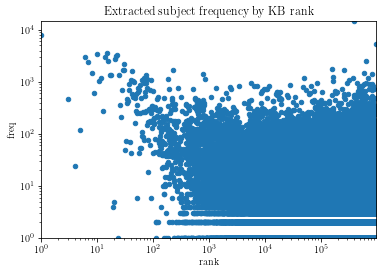

In [43]:
triple_s = triples.map_partitions(lambda ts: [t.get('s') for t in ts if t['kind'] == 'property'])

s_freq = pd.Series({g.lookup_id('<%s>'%s):f for s,f in triple_s.frequencies()}, name='freq')
stail2 = stail.join(s_freq, on='index')
stail2 = stail2[~stail2['freq'].isna()]

ax = plot_tail('Extracted subject frequency by KB rank', stail2, 'rank', 'freq')
ax.get_figure().savefig('fig/extracted-subject-count-by-rank.png')
ax

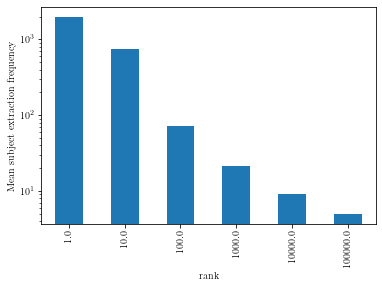

In [44]:
import numpy as np
smeans = stail2.groupby(10**np.floor(np.log10(stail2['rank'])))['freq'].mean()
ax = smeans.plot.bar(logy=True, ylabel='Mean subject extraction frequency')
ax.get_figure().savefig('fig/mean-subject-extraction-freq.png')
ax

## Object tail

100%|██████████| 966404/966404 [00:42<00:00, 22515.94it/s]


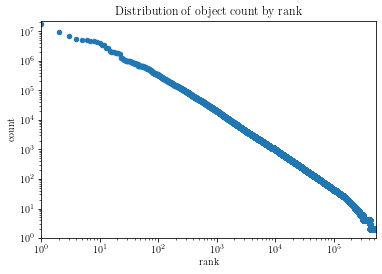

In [45]:
o_count = {s: g.count_o(s) for s in tqdm.tqdm(ss) if s and g.count_o(s) > 1}

import pandas as pd
otail = pd.Series(o_count).to_frame('count')
otail = otail.sort_values('count', ascending=False).reset_index()
otail['rank'] = otail.index

ax = plot_tail('Distribution of object count by rank', otail, 'rank', 'count')
ax.get_figure().savefig('fig/object-count-by-rank.png')
ax

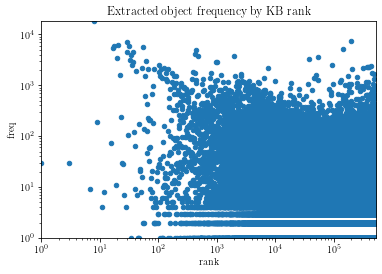

In [46]:
triple_o = triples.map_partitions(lambda ts: [t.get('o') for t in ts if t['kind'] == 'property' and isinstance(t.get('o'), str)])

o_freq = pd.Series({g.lookup_id('<%s>'%s):f for s,f in triple_o.frequencies()}, name='freq')
otail2 = otail.join(o_freq, on='index')
otail2 = otail2[~otail2['freq'].isna()]

ax = plot_tail('Extracted object frequency by KB rank', otail2, 'rank', 'freq')
ax.get_figure().savefig('fig/extracted-object-count-by-rank.png')
ax

/export/scratch1/home/kruit/venv2/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


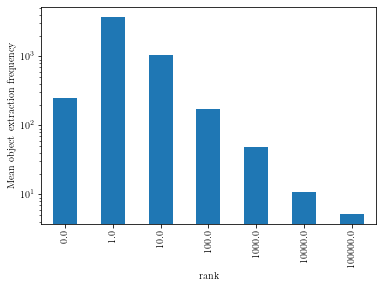

In [47]:
import numpy as np
omeans = otail2.groupby(10**np.floor(np.log10(otail2['rank'])))['freq'].mean()
ax = omeans.plot.bar(logy=True, ylabel='Mean object extraction frequency')
ax.get_figure().savefig('fig/mean-object-extraction-freq.png')
ax